# Import packages

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from joblib import dump

     |████████████████████████████████| 81kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [ ]:
# this is sa t

In [ ]:
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d'pschale/mlb-pitch-data-20152018'
!mkdir data
!unzip mlb-pitch-data-20152018.zip -d data

Saving kaggle.json to kaggle.json
 99% 368M/370M [00:03<00:00, 98.7MB/s]
100% 370M/370M [00:04<00:00, 85.7MB/s]
Archive:  mlb-pitch-data-20152018.zip
  inflating: data/2019_atbats.csv    
  inflating: data/2019_games.csv     
  inflating: data/2019_pitches.csv   
  inflating: data/atbats.csv         
  inflating: data/ejections.csv      
  inflating: data/games.csv          
  inflating: data/pitches.csv        
  inflating: data/player_names.csv   


In [ ]:
pitches = pd.read_csv('data/pitches.csv')
games = pd.read_csv('data/games.csv')
atbats =  pd.read_csv('data/atbats.csv')
player_names = pd.read_csv('data/player_names.csv')

In [ ]:
df = pd.merge(atbats, games, how= 'inner', on= 'g_id')

In [ ]:
from datetime import datetime
date = datetime.strptime(df['date'][0], '%Y-%m-%d')
date.day

# Wrangling

In [ ]:
def wrangle(df):
  df = df.copy()

  # Sorting at bats into 'on base' or 'out'
  df['event'].replace({
      'Strikeout': 'Out',
      'Groundout': 'Out',
      'Walk' : 'On Base',
      'Single' : 'On Base',
      'Flyout' : 'Out',
      'Lineout': 'Out',
      'Pop Out' : 'Out',
      'Double' : 'On Base',
      'Home Run' : 'On Base',
      'Forceout' : 'Out',
      'Grounded Into DP' : 'Out',
      'Field Error' : 'On Base', 
      'Hit By Pitch': 'On Base',
      'Triple' : 'On Base',
      'Double Play' : 'Out',
      'Intent Walk' : 'On Base',
      'Strikeout Double Play' : 'Out',
      'Fielders Choice' : 'Out',
      'Fielders Choice Out' : 'Out',
      'Bunt Pop Out' : 'Out',
      'Bunt Groundout' : 'Out',
      'Bunt Lineout' : 'Out',
      'Runner Out' : 'Out',
      'Triple Play' : 'Out',
      'Runner Double Play' : 'Out',
      'Strikeout - DP': 'Out',
      'Batter Interference': 'Out',
      'Catcher Interference' : 'On Base'

      # ,'Sac Fly': 'Out',
      # 'Sac Bunt': 'Out',
      # 'Sac Fly DP': 'Out',
      # 'Sacrifice Bunt DP': 'Out'
  }, inplace= True)

  # Filtering out sacrifice flys and bunts
  df = df[(df['event'] == 'On Base') | (df['event'] == 'Out')] 

  # Renaming abbreviated columns
  df = df.rename(mapper = {
      'ab_id': 'atbat_id',
      'event': 'result',
      'o': 'outs',
      'g_id': 'game_id', 
      'p_score': 'pitcher_team_score'
      }, axis= 1)
  
  # Making atbats readable
  df['atbat_id'] = df['atbat_id'].apply(int) 

  # Create feature for year, month, day of week
  def get_year(data):
    return str(data)[:4]
  df['year'] = df['game_id'].apply(get_year)

  #df = df.set_index('game_id')
  
  # Creating features and reducing cardinality of wind
  def wind_speed(data):
    return int(data.split(',')[0].strip()[:-4])
  def wind_direction(data):
    return data.split(',')[1].strip()
  df['wind_speed'] = df['wind'].apply(wind_speed)
  df['wind_direction'] = df['wind'].apply(wind_direction)
  df['wind_direction'].replace({'none': 'None'}, inplace= True)


  # Creating features for weather
  def temperature(data):
    return int(data.split(',')[0].strip()[:3])
  def weather(data):
    return data.split(',')[1].strip()
  df['temperature'] = df['weather'].apply(temperature)
  df['weather'] = df['weather'].apply(weather)

  # Duplicate, unnecessary, or potentailly data leakage columns
  df.drop(columns= ['outs', 'wind', 'away_final_score', 'home_final_score', 'atbat_id', 'game_id'], inplace= True)

  # Drop high cardinality columns
  high_card = [col for col in df.select_dtypes(include= 'object').columns if df[col].nunique() >= 100]
  df.drop(columns = high_card, inplace= True)
  #df.drop(columns= ['umpire_1B', 'umpire_2B', 'umpire_3B', 'umpire_HP'], inplace= True)

  # Assigning names to pitcher and batter ids
  player_names['name'] = player_names['first_name'] + ' ' + player_names['last_name']
  player_names.drop(columns= ['first_name', 'last_name'], inplace= True)
  player_names['batter_id'] = player_names['id']
  player_names['batter'] = player_names['name']
  player_names.drop(columns= ['id', 'name'], inplace=True)
  df = pd.merge(df, player_names, how= 'inner', on= 'batter_id')
  player_names['pitcher_id'] = player_names['batter_id']
  player_names['pitcher'] = player_names['batter']
  player_names.drop(columns= ['batter_id', 'batter'], inplace=True)
  df = pd.merge(df, player_names, how= 'inner', on= 'pitcher_id')
  df.drop(columns= ['batter_id', 'pitcher_id'], inplace= True)

  return df

In [ ]:
df = wrangle(df)
print(df.shape)
df.head()

(731567, 19)


,result,inning,pitcher_team_score,p_throws,stand,top,attendance,away_team,elapsed_time,home_team,venue_name,weather,delay,year,wind_speed,wind_direction,temperature,batter,pitcher
0,Out,1,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
1,On Base,2,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
2,On Base,5,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
3,On Base,1,2,L,L,False,42207,chn,176,sln,Busch Stadium,clear,0,2015,12,Out to LF,83,Matt Carpenter,Jon Lester
4,Out,3,3,L,L,False,42207,chn,176,sln,Busch Stadium,clear,0,2015,12,Out to LF,83,Matt Carpenter,Jon Lester


In [ ]:
df['wind_speed'].value_counts()

In [ ]:
df.select_dtypes(exclude= 'object').nunique()

In [ ]:
df['result'].value_counts()

In [ ]:
df.dtypes

## Wrangle pitches dataset

In [ ]:
pitches = pd.read_csv('data/pitches.csv')

In [ ]:
def wrangle_pitches(df):
  df = df.copy()

  # nulls = [col for col in df.columns if df[col].isnull().sum() == df.shape[0]]
  # print(nulls)
  # df.drop(columns= nulls, inplace= True)
  #df.drop(columns= ['code', 'o','event_num'], inplace= True) # code is duplicate of type, o is duplicate of outs, do not know what event_num is
  #df.drop(columns= ['spin_rate', 'spin_dir', 'type_confidence','zone'], inplace= True) # dropping placeholders. could use for advanced analysis
  #df.drop(columns= 'y0', inplace= True) # same value for all pitches: 50

  #advanced_stats = df.loc[:,:'pfx_z']
  #df.drop(columns= advanced_stats.columns, inplace= True)
  
  df = df.rename(mapper = {'ab_id': 'atbat_id', 
                           'g_id': 'game_id', 
                           'b_count':'balls', 
                           's_count':'strikes', 
                           'b_score':'batter_team_score', 
                           'p_score': 'pitcher_team_score'}, axis= 1)

  df['code'].replace({
      'B' : 'Ball', # ball
      '*B' : 'Ball', # ball in dirt
      'S' : 'Strike', # swinging strike
      'C' : 'Strike', # called strike
      'F' : 'Foul', # foul
      'T' : 'Foul', # foul tip
      'L' : 'Foul', # foul bunt
      'I' : 'Ball', # intentional ball
      'W' : 'Strike', # swinging strike blocked
      'M' : 'Strike', # missed bunt
      'P': 'Ball',
      'H': 'On Base', #'in play - no out', # hit by pitch
      'E': 'On Base', #'in play -  runs',
      'D': 'On Base', #'in play - no out',
      'X': 'Out', #'in play - out'
  }, inplace = True)

  # Selecting the walks when the ball count is at 3 and the pitch is a ball
  df.loc[(df['balls'] == 3) & (df['code'] == 'Ball'), 'code'] = 'On Base'

  # Selecting strikeouts when the strike count is at 2 and a strike is thrown
  df.loc[(df['strikes'] == 2) & (df['code'] == 'Strike'), 'code'] = 'Out'

  df = df[(df['code'] == 'Ball') | (df['code'] == 'Strike') | (df['code'] == 'Foul') | (df['code'] == 'On Base') | (df['code'] == 'Out')]

  df['pitch_type'].replace({
      'CH': 'Changeup',
      'CU': 'Curveball',
      'EP': 'Eephus',
      'FC': 'Cutter',
      'FF': 'Four seam fastball',
      'FO': 'Pitchout',
      'FS': 'Splitter',
      'FT': 'Two seam fastball',
      'IN': 'Intentional ball',
      'KC': 'Knuckle curve',
      'KN': 'Knuckleball',
      'PO': 'Pitchout',
      'SC': 'Screwball',
      'SI': 'Sinker',
      'SL': 'Slider',
      'UN': 'Unknown'
  }, inplace = True)

  # df['top'] = df['top'].astype(int) # changing 'top' of inning from boolean to binary

  df['atbbat_id'] = df['atbat_id'].apply(int) # making atbats readable

  # #df.dropna(inplace= True) 

  # Dropping outliers that have 4 balls in the count
  # four_balls = df[df['b_count'] == 4]
  # df.drop(four_balls.index, inplace= True)

  # Removing duplicate or data leakage
  df.drop(columns= ['type', 'event_num'], inplace= True)

  return df

In [ ]:
pitches = wrangle_pitches(pitches)
print(pitches.shape)
pitches.head()

(2854774, 40)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,pitch_type,event_num,batter_team_score,atbat_id,balls,strikes,outs,pitch_num,on_1b,on_2b,on_3b,atbbat_id
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,Strike,Four seam fastball,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015000001
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,Strike,Four seam fastball,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2015000001
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,Foul,Four seam fastball,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2015000001
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,Ball,Four seam fastball,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,2015000001
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,Ball,Curveball,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,2015000001


In [ ]:
pitches['code'].value_counts()

Ball       970852
Strike     629856
Foul       528930
Out        478233
On Base    246903
Name: code, dtype: int64

In [ ]:
pitchers = df.groupby(['pitcher_id'])#['pitcher_id']
pitchers.head()

## Wrangle at_bats dataset

In [ ]:
at_bats = pd.read_csv('data/atbats.csv')

In [ ]:
def wrangle_at_bats(df):
  df = df.copy()

  # df['event'].replace({
  #     'Strikeout': 'Out',
  #     'Groundout': 'Out',
  #     'Walk' : 'On Base',
  #     'Single' : 'On Base',
  #     'Flyout' : 'Out',
  #     'Lineout': 'Out',
  #     'Pop Out' : 'Out',
  #     'Double' : 'On Base',
  #     'Home Run' : 'On Base',
  #     'Forceout' : 'Out',
  #     'Grounded Into DP' : 'Out',
  #     'Field Error' : 'On Base', # counted as on base since the batter did get on base
  #     'Hit By Pitch': 'On Base',
  #     'Triple' : 'On Base',
  #     'Double Play' : 'Out',
  #     'Intent Walk' : 'On Base',
  #     'Strikeout Double Play' : 'Out',
  #     'Fielders Choice' : 'Out',
  #     'Fielders Choice Out' : 'Out',
  #     'Bunt Pop Out' : 'Out',
  #     'Bunt Groundout' : 'Out',
  #     'Bunt Lineout' : 'Out',
  #     'Runner Out' : 'Out',
  #     'Triple Play' : 'Out',
  #     'Runner Double Play' : 'Out',
  #     'Strikeout - DP': 'Out',
  #     'Batter Interference': 'Out',
  #     'Catcher Interference' : 'On Base'

  #     # ,'Sac Fly': 'Out',
  #     # 'Sac Bunt': 'Out',
  #     # 'Sac Fly DP': 'Out',
  #     # 'Sacrifice Bunt DP': 'Out'
  # }, inplace= True)

  # df = df[(df['event'] == 'On Base') | (df['event'] == 'Out')] # filtering out sacrifice flys and bunts

  # df['event'].replace({
  #     'Out': 0,
  #     'On Base': 1
  # }, inplace = True)

  # df['top'] = df['top'].astype(int)
  
  df = df.rename(mapper = {'ab_id': 'atbat_id',
                           'event': 'result',
                           'o': 'outs',
                           'g_id': 'game_id', 
                           'p_score': 'pitcher_team_score'}, axis= 1)
  
  df['atbat_id'] = df['atbat_id'].apply(int) # making atbats readable

  # Removing data leakage
  df.drop(columns= ['outs', 'result'], inplace= True)
  return df



In [ ]:
at_bats = wrangle_at_bats(at_bats)
print(at_bats.shape)
at_bats.head()

(740389, 10)


,atbat_id,batter_id,game_id,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,atbbat_id
0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001
1,2015000002,518792,201500001,1,0,L,452657,L,True,2015000002
2,2015000003,407812,201500001,1,0,L,452657,R,True,2015000003
3,2015000004,425509,201500001,1,0,L,452657,R,True,2015000004
4,2015000005,571431,201500001,1,0,L,452657,L,True,2015000005


In [ ]:
at_bats['result'].value_counts(normalize = True)*100

In [ ]:
at_bats['outs'].value_counts()

In [ ]:
at_bats.groupby(by= 'outs')['result'].sum() / at_bats.groupby(by= 'outs')['result'].count()

In [ ]:
at_bats.nunique()

## Wrangle games dataset

In [ ]:
games = pd.read_csv('data/games.csv')

In [ ]:
def wrangle_games(df):
  df = df.copy()

  df = df.rename(mapper = {'g_id': 'game_id'}, axis= 1)

  # Create feature for year
  def get_year(data):
    return str(data)[:4]
  df['year'] = df['game_id'].apply(get_year)

  df = df.set_index('game_id')
  
  # Creating features and reducing cardinality of wind
  def wind_speed(data):
    return int(data.split(',')[0].strip()[:-4])
  def wind_direction(data):
    return data.split(',')[1].strip()
  df['wind_speed'] = df['wind'].apply(wind_speed)
  df['wind_direction'] = df['wind'].apply(wind_direction)
  df['wind_direction'].replace({'none': 'None'}, inplace= True)


  # Creating features for weather
  def temperature(data):
    return int(data.split(',')[0].strip()[:3])
  def weather(data):
    return data.split(',')[1].strip()
  df['temperature'] = df['weather'].apply(temperature)
  df['weather'] = df['weather'].apply(weather)

  # Duplicate or potentailly data leakage columns
  df.drop(columns= ['wind', 'away_final_score', 'home_final_score'], inplace= True)

  # Drop high cardinality columns
  high_card = [col for col in df.columns if df[col].nunique() >= 100]
  df.drop(columns = high_card, inplace= True)
  #df.drop(columns= ['umpire_1B', 'umpire_2B', 'umpire_3B', 'umpire_HP'], inplace= True)
  return df

In [ ]:
games = wrangle_games(games)
print(games.shape)
games.head()

(9718, 8)


,away_team,home_team,venue_name,weather,year,wind_speed,wind_direction,temperature
game_id,,,,,,,,
201500001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
201500002,ana,sea,Safeco Field,cloudy,2015,1,Varies,54
201500003,atl,mia,Marlins Park,partly cloudy,2015,16,In from CF,80
201500004,bal,tba,Tropicana Field,dome,2015,0,None,72
201500005,bos,phi,Citizens Bank Park,partly cloudy,2015,11,Out to RF,71


In [ ]:
games.nunique()

away_team         30
home_team         30
venue_name        39
weather           10
year               4
wind_speed        27
wind_direction    11
temperature       78
dtype: int64

In [ ]:
%matplotlib inline
games['attendance'].hist();

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 201500001 to 201802431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   away_final_score  9718 non-null   int64 
 1   away_team         9718 non-null   object
 2   home_final_score  9718 non-null   int64 
 3   home_team         9718 non-null   object
 4   venue_name        9718 non-null   object
 5   weather           9718 non-null   object
 6   wind_speed        9718 non-null   int64 
 7   wind_direction    9718 non-null   object
 8   temperature       9718 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 759.2+ KB


In [ ]:
games['attendance'].hist()
plt.show();

## Merge the datasets

In [ ]:
df = pd.merge(pitches, at_bats, how= 'inner', on= 'atbat_id')
df = pd.merge(df, games, how= 'inner', on= 'game_id')

In [ ]:
print(df.shape)
df.head()

(2854774, 57)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,pitch_type,event_num,batter_team_score,atbat_id,balls,strikes,outs,pitch_num,on_1b,on_2b,on_3b,atbbat_id_x,batter_id,game_id,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,atbbat_id_y,away_team,home_team,venue_name,weather,year,wind_speed,wind_direction,temperature
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,Strike,Four seam fastball,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,Strike,Four seam fastball,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,Foul,Four seam fastball,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,Ball,Four seam fastball,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,Ball,Curveball,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44


In [ ]:
id_cols = [col for col in df.columns if '_id' in col]
id_cols

['atbat_id', 'atbbat_id', 'batter_id', 'game_id', 'pitcher_id']

## Subsetting

In [ ]:
print(df.shape)
df.head()

(63285, 19)


,result,inning,pitcher_team_score,p_throws,stand,top,attendance,away_team,elapsed_time,home_team,venue_name,weather,delay,year,wind_speed,wind_direction,temperature,batter,pitcher
0,Out,1,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
1,On Base,2,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
2,On Base,5,0,L,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44,Matt Carpenter,Jon Lester
3,On Base,1,2,L,L,False,42207,chn,176,sln,Busch Stadium,clear,0,2015,12,Out to LF,83,Matt Carpenter,Jon Lester
4,Out,3,3,L,L,False,42207,chn,176,sln,Busch Stadium,clear,0,2015,12,Out to LF,83,Matt Carpenter,Jon Lester


In [ ]:
df_2015 = df[df['year'] == '2015']

In [ ]:
# Getting home and away games for oakland
oakland = df[(df['away_team'] == 'oak') | (df['home_team'] == 'oak')]

In [ ]:
oakland_2015 = oakland[oakland['year'] == '2015']

In [ ]:
print(oakland.shape)

(190638, 57)


In [ ]:
print(oakland_2015.shape)

(47305, 54)


# Modeling

In [ ]:
df = wrangle(df)

In [ ]:
df = df_2015

In [ ]:
df.shape

(181685, 19)

In [ ]:
np.nan

nan

In [ ]:
df.describe()

,inning,pitcher_team_score,attendance,elapsed_time,delay,wind_speed,temperature
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,3.514959,1.620624,29392.349459,186.714195,4.309994,7.990452,72.737747
std,2.133506,2.179507,9627.451626,28.074272,25.265898,5.127474,10.915657
min,1.000000,0.000000,1.000000,133.000000,0.000000,0.000000,27.000000
25%,1.000000,0.000000,22346.000000,167.500000,0.000000,4.000000,68.000000
50%,3.000000,1.000000,30665.000000,184.000000,0.000000,8.000000,73.000000
75%,5.000000,3.000000,37030.000000,200.000000,0.000000,12.000000,80.000000
max,9.000000,14.000000,53598.000000,386.000000,290.000000,22.000000,103.000000


In [ ]:
df['batter'].nunique()

956

In [ ]:
most_at_bats = df['batter'].value_counts().head(100)
most_used_pitcher = df['pitcher'].value_counts().head(100)

In [ ]:
most_at_bats = df['batter'].value_counts().head(10)
most_used_pitcher = df['pitcher'].value_counts().head(10)

In [ ]:
def top_100_batters(name):
  if name in most_at_bats:
    return name
  else:
    return np.nan

In [ ]:
def top_100_pitchers(name):
  if name in most_used_pitcher:
    return name
  else:
    return np.nan

In [ ]:
df['batter'] = df['batter'].apply(top_100_batters)


In [ ]:
df['pitcher'] = df['pitcher'].apply(top_100_pitchers)

In [ ]:
df.dropna(axis= 0, inplace= True)

In [ ]:
df['batter'].value_counts()

Ian Kinsler        946
Manny Machado      918
Brian Dozier       904
Evan Longoria      880
Alcides Escobar    878
                  ... 
Brett Lawrie       390
Billy Butler       342
Alex Rodriguez     332
Jimmy Rollins      286
Torii Hunter       267
Name: batter, Length: 100, dtype: int64

In [ ]:
df.describe()

,inning,pitcher_team_score,attendance,elapsed_time,delay,wind_speed,temperature
count,234373.000000,234373.000000,234373.000000,234373.000000,234373.000000,234373.000000,234373.000000
mean,4.826823,2.171393,29871.027870,187.326697,4.033617,7.529344,73.711166
std,2.715497,2.540190,10026.476072,28.933137,27.683415,5.015617,10.706629
min,1.000000,0.000000,0.000000,75.000000,0.000000,0.000000,27.000000
25%,3.000000,0.000000,22045.000000,169.000000,0.000000,4.000000,68.000000
50%,5.000000,1.000000,30316.000000,184.000000,0.000000,7.000000,74.000000
75%,7.000000,3.000000,37821.000000,201.000000,0.000000,11.000000,81.000000
max,19.000000,24.000000,56310.000000,409.000000,1860.000000,28.000000,108.000000


In [ ]:
df.columns

Index(['result', 'inning', 'pitcher_team_score', 'p_throws', 'stand', 'top',
       'attendance', 'away_team', 'elapsed_time', 'home_team', 'venue_name',
       'weather', 'delay', 'year', 'wind_speed', 'wind_direction',
       'temperature', 'batter', 'pitcher'],
      dtype='object')

In [ ]:
nans = []
for i in range(len(df.columns)):
  nans.append('np.NaN')

In [ ]:
df.shape

(234373, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82262 entries, 0 to 686427
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   result              82262 non-null  object
 1   inning              82262 non-null  int64 
 2   pitcher_team_score  82262 non-null  int64 
 3   p_throws            82262 non-null  object
 4   stand               82262 non-null  object
 5   top                 82262 non-null  bool  
 6   attendance          82262 non-null  int64 
 7   away_team           82262 non-null  object
 8   elapsed_time        82262 non-null  int64 
 9   home_team           82262 non-null  object
 10  venue_name          82262 non-null  object
 11  weather             82262 non-null  object
 12  delay               82262 non-null  int64 
 13  year                82262 non-null  object
 14  wind_speed          82262 non-null  int64 
 15  wind_direction      82262 non-null  object
 16  temperature         8

## Baseline

In [ ]:
print('Baseline:\n', round(df['result'].value_counts(normalize = True)*100, 3),'%')


Baseline:
 Out        64.591
On Base    35.409
Name: result, dtype: float64 %


## Train - test split

In [ ]:
target = 'result'
y = df[target]
X = df.drop(columns= target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## First model 0.782
- using at_bats
- no features
- random forest : no tuning
- predicted probabilites


In [ ]:
y = at_bats['result']
X = at_bats.loc[:,'inning':]
X = X.drop(columns= 'pitcher_id')

# Splitting out test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs= -1,
        verbose= 1),
);
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction', 'batter',
                                      'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_typ...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=Non

In [ ]:
score = cross_val_score(model, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished


In [ ]:
print('CV accuracy score:', score.mean())

CV accuracy score: 0.5893774237203825


In [ ]:
y_pred_proba = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:,1]

In [ ]:
y_plot = y_pred_proba.copy()
y_plot = sorted(y_plot)[:]

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(10)
fig.set_figwidth(20)
plt.title('Prediction Probabilities')
plt.scatter(x= np.arange(len(y_plot)), y= y_plot, marker= '.')
plt.show();

## Second model 0.784
- using at_bats
- no features
- XGBoost

In [ ]:
y = at_bats['result']
X = at_bats.loc[:,'inning':]
X = X.drop(columns= 'pitcher_id')

# Splitting out test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
xgb_model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)
xgb_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction', 'batter',
                                      'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_typ...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, lear

In [ ]:
xgb_score = cross_val_score(xgb_model, X_train, y_train, scoring= 'accuracy', verbose= 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.7s finished


In [ ]:
print('XGB training accuracy:', xgb_score.mean())

XGB training accuracy: 0.6776470724069793


## Third model 0.782
- low-card games and at_bats
- XGBoost
- no tuning

In [ ]:
y = df['result']
X = df.drop(columns= 'result')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
gb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs= -1)
)

In [ ]:
gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction', 'batter',
                                      'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_typ...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, lear

In [ ]:
score = cross_val_score(gb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.654467842914058


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


## Fourth model 0.584 accuracy
- classifying ball, strike, on base, out, or foul using all datasets
- removed data leakage columns: 
  - out, result, home_final_score, away_final_score

In [ ]:
y = df['code']
X = df.drop(columns= 'code')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
gb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs= -1)
)

In [ ]:
score = cross_val_score(gb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.5849276403389033


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [ ]:
gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['pitch_type', 'p_throws', 'stand',
                                      'away_team', 'home_team', 'venue_name',
                                      'weather', 'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'pitch_type',
                                          'data_type': dtype('O'),
                                          'mapping': Changeup               1
Four seam fastball     2
Two seam fastball      3
Sinker                 4
S...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                

## Fifth model 0.609 : 13.4 minutes to run cross-val scores
- using at_bats and games
- random forest
- more features and wrangling
- removed data leakage columns: outs, final score, 

In [ ]:
rf_model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        verbose = 1
    ),
)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtype('O'),
                                          'mapp...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth

In [ ]:
score = cross_val_score(rf_model, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6090921327549343


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


### Permutation importances

In [ ]:
perm_imp = permutation_importance(rf_model, 
                                  X_test, y_test)
                                  #n_jobs= -1) 
                                  #random_state= 42)

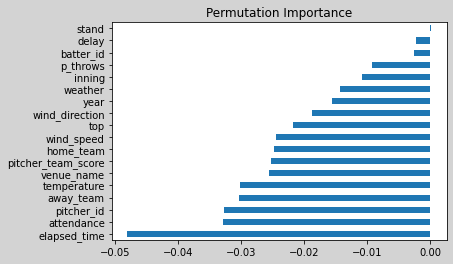

In [ ]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.savefig('perm_imp_model_5.png')
plt.show();

## Sixth model 0.66965 : 34 seconds to run cross val score
- logistic regression
- same data as fifth model

In [ ]:
lr = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(n_jobs = -1,
                       verbose = 1),
)
lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction', 'batter',
                                      'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_typ...
JB Shuck           1289
Luis Sardinas      1290
NaN                  -2
Length: 1291, dtype: int64}],
                                return_df=True, verbose=0)),
                ('logisticregression',

In [ ]:
score = cross_val_score(lr, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6467428988150795


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


In [ ]:
perm_imp = permutation_importance(lr, 
                                  X_test, y_test,
                                  #n_jobs= -1, 
                                  random_state= 42)


In [ ]:
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(6)
fig.set_figwidth(10)
perm_imp_df['importances_mean'].plot(kind= 'barh')
plt.xlabel('Change in Model Accuracy')
plt.title('Permutation Importance for Logistic Regression')
plt.rcParams['figure.dpi'] = 150
#plt.savefig('perm_imp_log_reg.png')

plt.show();

NameError: ignored

In [ ]:
df['pitcher'].value_counts()

Justin Verlander    1177
Chris Archer        1162
Kyle Gibson         1129
Rick Porcello       1127
Jose Quintana       1117
                    ... 
Johnny Field           1
Scooter Gennett        1
Mitch Garver           1
Jeremy Bleich          1
Josh Wilson            1
Name: pitcher, Length: 1298, dtype: int64

In [ ]:
batters = df['pitcher'].value_counts()
batters.head(100).index

Index(['Justin Verlander', 'Chris Archer', 'Kyle Gibson', 'Rick Porcello',
       'Jose Quintana', 'Corey Kluber', 'Cole Hamels', 'Max Scherzer',
       'Zack Greinke', 'Mike Leake', 'James Shields', 'Mike Fiers',
       'Dallas Keuchel', 'Jake Odorizzi', 'Chris Sale', 'Gerrit Cole',
       'Marco Estrada', 'Gio Gonzalez', 'Masahiro Tanaka', 'Julio Teheran',
       'Tanner Roark', 'Trevor Bauer', 'Carlos Carrasco', 'David Price',
       'Jacob deGrom', 'Carlos Martinez', 'CC Sabathia', 'J.A. Happ',
       'Kevin Gausman', 'Andrew Cashner', 'Ian Kennedy', 'Bartolo Colon',
       'Jon Lester', 'Sonny Gray', 'Felix Hernandez', 'Jason Hammel',
       'Wade Miley', 'Jake Arrieta', 'Kyle Hendricks', 'Jeff Samardzija',
       'Danny Duffy', 'Ervin Santana', 'Hector Santiago', 'Martin Perez',
       'Ivan Nova', 'Patrick Corbin', 'Anibal Sanchez', 'Clayton Kershaw',
       'Johnny Cueto', 'Jeremy Hellickson', 'Yovani Gallardo',
       'Chase Anderson', 'Jordan Zimmermann', 'Stephen Strasburg',

In [ ]:
wind_dir = df['wind_direction'].value_counts()
wind_dir.index

Index(['R to L', 'L to R', 'None', 'Out to CF', 'Out to RF', 'Out to LF',
       'In from RF', 'In from LF', 'In from CF', 'Varies', 'Calm'],
      dtype='object')

In [ ]:
df.columns

Index(['result', 'inning', 'pitcher_team_score', 'p_throws', 'stand', 'top',
       'attendance', 'away_team', 'elapsed_time', 'home_team', 'venue_name',
       'weather', 'delay', 'year', 'wind_speed', 'wind_direction',
       'temperature', 'batter', 'pitcher'],
      dtype='object')

In [ ]:
df.iloc[0]


result                           Out
inning                             1
pitcher_team_score                 0
p_throws                           L
stand                              L
top                             True
attendance                     35055
away_team                        sln
elapsed_time                     184
home_team                        chn
venue_name             Wrigley Field
weather                        clear
delay                              0
year                            2015
wind_speed                         7
wind_direction            In from CF
temperature                       44
batter                Matt Carpenter
pitcher                   Jon Lester
Name: 0, dtype: object

In [ ]:
df['batter'].nunique()

100

In [ ]:
df.to_csv('top_100_batters.csv')

### Permutation importances

In [ ]:
xgb_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction', 'batter',
                                      'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_typ...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, lear

In [ ]:
# took over ten minutes to run
perm_imp = permutation_importance(xgb_model, 
                                  X_test, y_test,
                                  #n_jobs= -1, 
                                  random_state= 42)

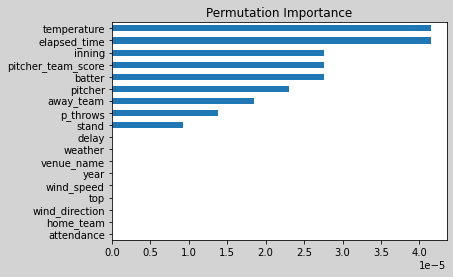

In [ ]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
#plt.savefig('perm_imp_model_6.png')

plt.show();

In [ ]:
df.nunique()

batter_id             342
result                  2
inning                 14
pitcher_team_score     19
p_throws                2
pitcher_id            310
stand                   2
top                     2
attendance            156
away_team              19
elapsed_time           78
home_team              19
venue_name             19
weather                 7
delay                   2
year                    1
wind_speed             21
wind_direction         10
temperature            37
dtype: int64

In [ ]:
df.shape

(12193, 19)

In [ ]:
df['batter_id'].value_counts()

543760    602
456714    599
543434    597
502210    582
542993    553
         ... 
518567      1
435623      1
544725      1
430605      1
475247      1
Name: batter_id, Length: 342, dtype: int64

In [ ]:
data

{'importances_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'importances_std': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])}

In [ ]:
from joblib import dump
lr_pickle = pickle.dumps(lr)
dump(lr, 'logreg_pickle.joblib')

['logreg_pickle.joblib']

## Seventh model 0.6718 : 42 seconds to run cross val scores
- baseline: 67.279
- using just 2015 data of fifth and sixth models
- xgboost

In [ ]:
xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtype('O'),
                                          'mapp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, 

In [ ]:
score = cross_val_score(xgb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6718289897837824


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished


### Permutation importances

In [ ]:
# took 
perm_imp = permutation_importance(xgb, 
                                  X_test, y_test,
                                  #n_jobs= -1, 
                                  random_state= 42)

In [ ]:
perm_imp

{'importances': array([[ 0.00000000e+00,  0.00000000e+00, -2.75201585e-05,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.75201585e-05, -2.75201585e-05,  0.000

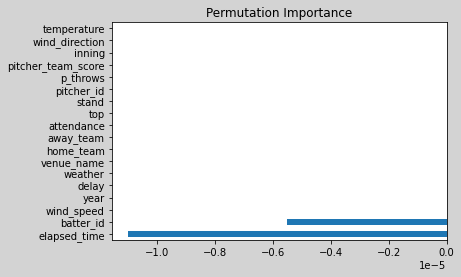

In [ ]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.savefig('perm_imp_model_6.png')

plt.show();

In [ ]:
from joblib import dump

dump(lr, 'logreg_pickle.joblib')

['logreg_pickle.joblib']

In [ ]:
df.to_csv('2015_data.csv')

## PDP

### One feature

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
feature = 'temperature'
isolated = pdp_isolate(
    model = gb,
    dataset = X_test,
    model_features = X_test.columns,
    feature= feature,
    num_grid_points = 70
)

pdp_plot(isolated, feature_name= feature);
plt.xlim(0, 100)

### Two features

In [ ]:
features = ['outs', 'inning']

interaction = pdp_interact(
    model= gb,
    features = features,
    dataset= X_test,
    model_features= X_test.columns
)

pdp_interact_plot(interaction, plot_type= 'grid', feature_names= features);

## Shapley

In [ ]:
import shap

In [ ]:
transformer = make_pipeline(
    OrdinalEncoder()
)
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

data = [(X_train_transformed, y_train),
        (X_test_transformed, y_test)]

model = XGBClassifier(n_jobs= -1)
model.fit(X_train_transformed, y_train, eval_set = data)#, eval_metric= 'accuracy')

In [ ]:
row = X_test.iloc[[1]]

In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = transformer.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()

shap.force_plot(
    base_value= explainer.expected_value,
    shap_values= shap_values,
    features= row,
    link= 'logit',
    matplotlib = True,
    show= False
)
plt.savefig('shapley.png', bbox_inches = 'tight')

## ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_curve_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate' : tpr,
    'Thresholds': thresholds
})
roc

## Feature Importances

In [ ]:
importances = lr.named_steps['logisticregression'].feature_importances_

AttributeError: ignored

In [ ]:
feat_imp = pd.Series(importances, index= X_train.columns).sort_values()

In [ ]:
print(X_train.columns)

In [ ]:
print(feat_imp)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
plt.title('Feature Importance for Random Forest Using Gini')
feat_imp.plot(kind= 'barh', xlabel = 'feature', ylabel= 'importance');

y0                    0.000000
p_throws              0.000000
pitcher_team_score    0.000000
venue_name            0.000000
top                   0.000000
year                  0.000000
weather               0.001143
break_y               0.001258
wind_direction        0.001487
away_team             0.002426
wind_speed            0.002501
ay                    0.002566
type_confidence       0.003086
home_team             0.003342
start_speed           0.003468
x0                    0.003687
pitcher_id            0.003745
temperature           0.003833
spin_rate             0.003904
z0                    0.004414
inning                0.004490
batter_id             0.004973
batter_team_score     0.005516
on_2b                 0.005961
on_1b                 0.006357
end_speed             0.006520
vx0                   0.007436
pitch_type            0.008306
sz_top                0.008350
ax                    0.008528
on_3b                 0.009331
vy0                   0.009546
pfx_z   

## Permutation importance

In [ ]:
# perm_imp = permutation_importance(model, 
#                                   X_val, y_val, 
#                                   n_jobs= -1, 
#                                   random_state= 42)
perm_imp = permutation_importance(gb, 
                                  X_test, y_test, 
                                  n_jobs= -1, 
                                  random_state= 42)

In [ ]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

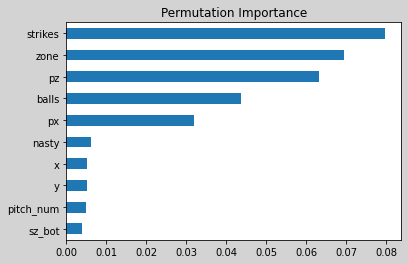

In [ ]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].tail(10).plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.show();